### 1. Load Libraries

In [21]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

### 2. Load Data

In [22]:
# Paths
GESTURE_IMAGE_PATH = "Data/Gesture Image Data"
PREPROCESSED_IMAGE_PATH = "Data/Gesture Image Pre-Processed Data"

# Định nghĩa nhãn
CLASSES = ["F", "G", "H", "I", "J"]
IMG_SIZE = 50  # Kích thước ảnh

def load_data(image_path, preprocessed_path):
    images, labels, pred_masks = [], [], []
    
    for class_name in CLASSES:  # Duyệt đúng thứ tự F -> J
        class_dir = os.path.join(image_path, class_name)
        preprocessed_dir = os.path.join(preprocessed_path, class_name)

        # Kiểm tra thư mục có tồn tại không
        if not os.path.exists(class_dir) or not os.path.exists(preprocessed_dir):
            print(f"Folder không tồn tại: {class_dir} hoặc {preprocessed_dir}")
            continue

        for img_name in os.listdir(class_dir):  # Lặp qua từng ảnh
            img_path = os.path.join(class_dir, img_name)
            preprocessed_img_path = os.path.join(preprocessed_dir, img_name)

            # Đọc ảnh gốc
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0  # Chuẩn hóa

            # Đọc ảnh đã xử lý trước nếu có
            if os.path.exists(preprocessed_img_path):
                pred_mask = cv2.imread(preprocessed_img_path, cv2.IMREAD_GRAYSCALE)
                pred_mask = cv2.resize(pred_mask, (IMG_SIZE, IMG_SIZE))
                pred_mask = pred_mask / 255.0  # Chuẩn hóa mask
            else:
                pred_mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)

            images.append(img)
            labels.append(CLASSES.index(class_name))  # Chuyển thành số 0-4
            pred_masks.append(pred_mask)

    # Chuyển thành numpy array
    images = np.array(images)
    labels = np.array(labels)
    pred_masks = np.array(pred_masks)

    # One-hot encode labels
    labels = to_categorical(labels, num_classes=len(CLASSES))

    return images, labels, pred_masks

# Load data
X, y, pred_masks = load_data(GESTURE_IMAGE_PATH, PREPROCESSED_IMAGE_PATH)

In [23]:
print("X shape:", X.shape)

X shape: (7500, 50, 50, 3)


In [24]:
print("y shape:", y.shape)

y shape: (7500, 5)


In [25]:
print("pred_masks shape:", pred_masks.shape)

pred_masks shape: (7500, 50, 50)


### 3. Train-Validation-Test Split

In [26]:
X_train, X_temp, y_train, y_temp, mask_train, mask_temp = train_test_split(X, y, pred_masks, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test, mask_valid, mask_test = train_test_split(X_temp, y_temp, mask_temp, test_size=0.5, random_state=42)

### 4. Data Visualization

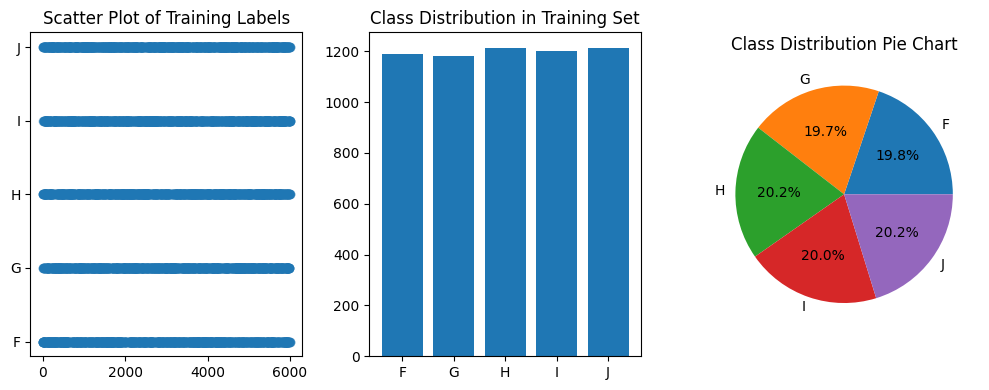

In [27]:
# Chuyển one-hot encoding về nhãn số (0, 1, 2, 3, 4)
y_train_labels = np.argmax(y_train, axis=1)

plt.figure(figsize=(10, 4))

# Scatter plot
plt.subplot(1, 3, 1)
plt.scatter(range(len(y_train_labels)), y_train_labels, alpha=0.5)
plt.title("Scatter Plot of Training Labels")
plt.yticks([0, 1, 2, 3, 4], ["F", "G", "H", "I", "J"])

# Bar plot (đếm số lượng từng nhãn)
plt.subplot(1, 3, 2)
unique_labels, counts = np.unique(y_train_labels, return_counts=True)
plt.bar(unique_labels, counts)
plt.xticks(unique_labels, ["F", "G", "H", "I", "J"]) 
plt.title("Class Distribution in Training Set")

# Pie chart (tương tự bar plot)
plt.subplot(1, 3, 3)
plt.pie(counts, labels=["F", "G", "H", "I", "J"], autopct='%1.1f%%')
plt.title("Class Distribution Pie Chart")

plt.tight_layout()
plt.show()

### 5. Feature Extraction with Transfer Learning

In [28]:
def build_model(base_model):
    base_model.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    output = Dense(y.shape[1], activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [29]:
vgg16_model = build_model(VGG16(weights='imagenet', include_top=False, input_shape=(50, 50, 3)))
print("VGG16 Model Summary:")
vgg16_model.summary()

VGG16 Model Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 50, 50, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,997 (56.39 MB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [30]:
resnet50_model = build_model(ResNet50(weights='imagenet', include_top=False, input_shape=(50, 50, 3)))
print("ResNet50 Model Summary:")
resnet50_model.summary()

ResNet50 Model Summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 50, 50, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 56, 56, 3) │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 25, 25,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 25, 25,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 25, 25,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 27, 27,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 13, 13,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 13, 13,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 13, 13,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 13, 13,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 13, 13,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 13, 13,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 13, 13,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 13, 13,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 13, 13,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 13, 13,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 13, 13,    │      1,024 │ conv2_block1_3_c

 Total params: 24,637,061 (93.98 MB)

 Trainable params: 1,049,349 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### 6. Train Models

In [31]:
print("Traning VGG16 model")
vgg16_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=32)
vgg16_model.save("Weights/vgg16_model.h5")

Traning VGG16 model
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 59s 303ms/step - accuracy: 0.8905 - loss: 0.5053 - val_accuracy: 1.0000 - val_loss: 0.0289
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 48s 252ms/step - accuracy: 1.0000 - loss: 0.0208 - val_accuracy: 1.0000 - val_loss: 0.0085
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 46s 245ms/step - accuracy: 1.0000 - loss: 0.0071 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 43s 231ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 46s 244ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 45s 238ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 45s 237ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 8.3589e-04
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 45s 240ms/step - ac

In [32]:
print("Training Resnet50 model")
resnet50_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=32)
resnet50_model.save("Weights/resnet50_model.h5")

Training Resnet50 model
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 192ms/step - accuracy: 0.5618 - loss: 1.1794 - val_accuracy: 0.8680 - val_loss: 0.4405
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 174ms/step - accuracy: 0.8748 - loss: 0.3843 - val_accuracy: 0.8987 - val_loss: 0.2703
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 174ms/step - accuracy: 0.9072 - loss: 0.2665 - val_accuracy: 0.9507 - val_loss: 0.1759
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 174ms/step - accuracy: 0.9532 - loss: 0.1770 - val_accuracy: 0.9653 - val_loss: 0.1368
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 176ms/step - accuracy: 0.9600 - loss: 0.1380 - val_accuracy: 0.9787 - val_loss: 0.1029
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 174ms/step - accuracy: 0.9632 - loss: 0.1221 - val_accuracy: 0.9800 - val_loss: 0.0895
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 32s 173ms/step - accuracy: 0.9694 - loss: 0.1038 - val_accuracy: 0.9893 - val_loss: 0.0705
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 173ms/step - ac

### 7. Evaluate Models

In [33]:
from tensorflow.keras.models import load_model

# Load saved models
vgg16_model = load_model("Weights/vgg16_model.h5")
resnet50_model = load_model("Weights/resnet50_model.h5")

In [34]:
y_pred_vgg16 = np.argmax(vgg16_model.predict(X_test), axis=1)
y_pred_resnet50 = np.argmax(resnet50_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
class_labels = ["F", "G", "H", "I", "J"]

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step


In [35]:
print("VGG16 Classification Report:")
print(classification_report(y_true, y_pred_vgg16, target_names=class_labels))

VGG16 Classification Report:
              precision    recall  f1-score   support

           F       1.00      1.00      1.00       143
           G       1.00      1.00      1.00       163
           H       1.00      1.00      1.00       150
           I       1.00      1.00      1.00       145
           J       1.00      1.00      1.00       149

    accuracy                           1.00       750
   macro avg       1.00      1.00      1.00       750
weighted avg       1.00      1.00      1.00       750



In [36]:
print("ResNet50 Classification Report:")
print(classification_report(y_true, y_pred_resnet50, target_names=class_labels))

ResNet50 Classification Report:
              precision    recall  f1-score   support

           F       0.98      1.00      0.99       143
           G       0.99      0.94      0.97       163
           H       0.94      0.99      0.97       150
           I       1.00      0.98      0.99       145
           J       1.00      1.00      1.00       149

    accuracy                           0.98       750
   macro avg       0.98      0.98      0.98       750
weighted avg       0.98      0.98      0.98       750



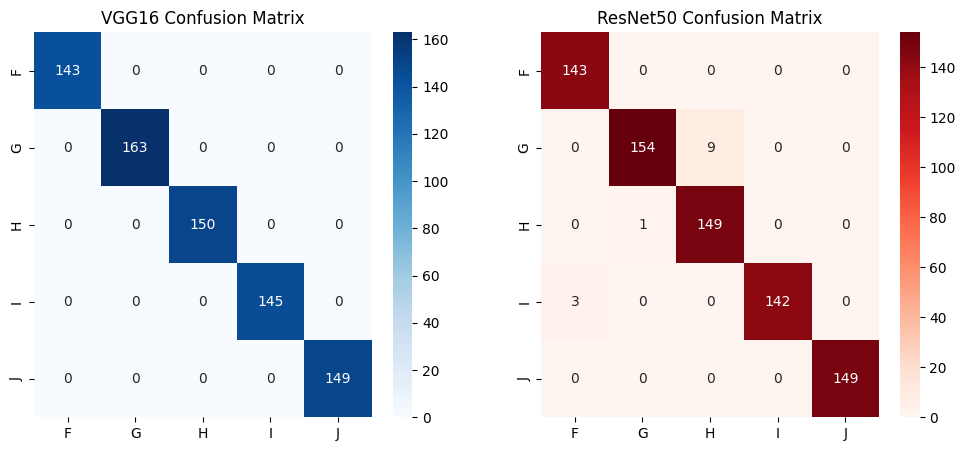

In [37]:
# Danh sách nhãn chữ
class_labels = ["F", "G", "H", "I", "J"]
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_true, y_pred_vgg16), annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("VGG16 Confusion Matrix")
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_true, y_pred_resnet50), annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.title("ResNet50 Confusion Matrix")
plt.show()

### 8. Test with Video without MediaPipe

In [38]:
# Danh sách nhãn chữ
class_labels = ["F", "G", "H", "I", "J"]

def test_video(model, name):
    cap = cv2.VideoCapture(0)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        img = cv2.resize(frame, (50, 50)) / 255.0
        img = np.expand_dims(img, axis=0)

        pred_index = np.argmax(model.predict(img))
        pred_label = class_labels[pred_index]  # Lấy nhãn chữ từ danh sách

        cv2.putText(frame, f"{name}: {pred_label}", (50, 50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        cv2.imshow(name, frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Chạy thử với VGG16 và ResNet50
test_video(vgg16_model, "VGG16")
test_video(resnet50_model, "ResNet50")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━

### 9. Test with Video with MediaPipe

In [39]:
import mediapipe as mp

class_labels = ["F", "G", "H", "I", "J"]

# Khởi tạo MediaPipe
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def test_video_mediapipe(model, name):
    hands = mp_hands.Hands(static_image_mode=False, 
                           max_num_hands=1, 
                           min_detection_confidence=0.5, 
                           min_tracking_confidence=0.5)
    
    cap = cv2.VideoCapture(0)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(img_rgb)

        if results.multi_hand_landmarks:
            # Resize ảnh về (50,50) và chuẩn hóa
            img = cv2.resize(frame, (50, 50)) / 255.0
            img = np.expand_dims(img, axis=0)

            # Lấy nhãn dự đoán
            pred_index = np.argmax(model.predict(img))
            pred_label = class_labels[pred_index]

            # Hiển thị nhãn dự đoán
            cv2.putText(frame, f"{name} + MediaPipe: {pred_label}", (50, 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # Vẽ landmark bàn tay
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        cv2.imshow(name, frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Chạy thử với VGG16 và ResNet50
test_video_mediapipe(vgg16_model, "VGG16")
test_video_mediapipe(resnet50_model, "ResNet50")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

### 10. Convert into voice (still in development mode)

In [40]:
import pyttsx3

# Khởi tạo Text-to-Speech
engine = pyttsx3.init()
labels = ["F", "G", "H", "I", "J"] 

# MediaPipe Hand Tracking
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils 
hands = mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.7)

def test_video_speech(model, name):
    cap = cv2.VideoCapture(0)
    last_pred = None  # Tránh lặp lại cùng một âm thanh liên tục

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(img_rgb)

        if results.multi_hand_landmarks:
            img_resized = cv2.resize(frame, (50, 50)) / 255.0
            img_expanded = np.expand_dims(img_resized, axis=0)

            pred_index = np.argmax(model.predict(img_expanded))
            pred_label = labels[pred_index]

            # Hiển thị kết quả lên màn hình
            cv2.putText(frame, f"{name} + TTS: {pred_label}", (50, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

            # Đọc nhãn bằng giọng nói nếu khác lần trước
            if pred_label != last_pred:
                engine.say(pred_label)
                engine.runAndWait()
                last_pred = pred_label

            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        cv2.imshow(name, frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Chạy thử nghiệm với mô hình
test_video_speech(vgg16_model, "VGG16")
test_video_speech(resnet50_model, "ResNet50")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━